# Branch Detection Benchmark


This notebook compares several clustering algorithms on their ability to detect
branches in a dataset's manifold that do not contain local density maxima. Our
synthetic dataset contains several n-point star-shaped clusters and some uniform
random noise. The stars have a density maximum in their centre, and the density
decreases along their arms. A grid search is used to find the algorithms'
optimal parameter values, before their Adjusted Rand Index is used to compare
their performance.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import product
from collections import defaultdict

from scipy import linalg
from sklearn.utils import shuffle
from sklearn.metrics.cluster import adjusted_rand_score

from lib.cdc import CDC
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from fast_hbcc import HBCC, BoundaryClusterDetector
from fast_hdbscan import HDBSCAN, BranchDetector

## Datasets

The functions below make our benchmark dataset of 4 stars with varying densities
and arms. The plot shows the ground-truth labels we will use to compute ARI
scores.

In [3]:
def make_star(
    num_dimensions=2,
    num_branches=3,
    points_per_branch=100,
    branch_length=2,
    noise_scale=0.02,
):
    """Creates a n-star in d dimensions."""

    def rotation(axis=[0, 0, 1], theta=0):
        return linalg.expm(np.cross(np.eye(3), axis / linalg.norm(axis) * theta))

    def rotate(X, axis=[0, 0, 1], theta=0):
        M = rotation(axis=axis, theta=theta)
        data = np.hstack((X, np.zeros((X.shape[0], 1), dtype=X.dtype)))
        return (M @ data.T).T[:, :2]

    max_exp = np.log(branch_length)
    branch = np.zeros((points_per_branch, 2))
    branch[:, 0] = np.exp(np.linspace(0, max_exp, points_per_branch)) - 1
    branches = np.concatenate(
        [
            rotate(branch, theta=theta)
            for theta in np.linspace(0, 2 * np.pi, num_branches, endpoint=False)
            + np.pi / 2
        ]
    )
    X = np.column_stack((branches, np.zeros((branches.shape[0], num_dimensions - 2))))
    X += np.random.normal(
        scale=np.sqrt(1 / num_dimensions) * noise_scale,
        size=X.shape,
    )
    y = np.repeat(np.arange(num_branches), points_per_branch)
    return X, y


def make_stars_dataset(size_factor=1, num_dimensions=2):
    num_branches = [3, 10, 4, 5]
    branch_lengths = [1.8, 3.5, 2.3, 2]
    points_per_branch = [40, 100, 150, 20]
    noise_scales = [0.2, 0.1, 0.2, 0.02]
    origins = np.array(
        [
            [7, 1],
            [2, 3],
            [5.5, 3],
            [7, 5],
        ]
    )

    # Make individual starts
    Xs, ys = zip(
        *[
            make_star(
                num_dimensions=num_dimensions,
                num_branches=nb,
                branch_length=l,
                points_per_branch=int(np * size_factor),
                noise_scale=s,
            )
            for l, np, nb, s in zip(
                branch_lengths, points_per_branch, num_branches, noise_scales
            )
        ]
    )

    # Concatenate to one dataset
    X = np.concatenate(
        [
            x + np.concatenate((o, np.zeros(num_dimensions - 2)))
            for x, o in zip(Xs, origins)
        ]
    )
    y = np.concatenate(
        [y + nb for y, nb in zip(ys, [0] + np.cumsum(num_branches).tolist())]
    )

    # Add uniform noise points
    num_noise_points = X.shape[0] // 20
    noise_points = np.random.uniform(
        low=X.min(axis=0), high=X.max(axis=0), size=(num_noise_points, num_dimensions)
    )
    noise_labels = np.repeat(-1, num_noise_points)
    X = np.concatenate((X, noise_points))
    y = np.concatenate((y, noise_labels))

    # Shuffle the data
    return shuffle(X, y)

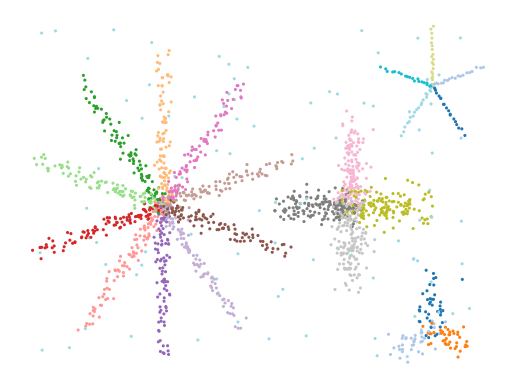

In [4]:
X, y = make_stars_dataset()
plot_kwargs = dict(s=5, cmap="tab20", vmin=0, vmax=19, edgecolors="k", linewidths=0)
plt.scatter(*X.T, c=y % 20, **plot_kwargs)
plt.axis("off")
plt.show()

## Parameter Sweep

A parameter grid-search is used to find the optimal parameters for each
algorithm. This ensures we are comparing the algorithms on their best
performance. Searching all parameter combinations for all algorithms creates a
too large search space. Instead we chose to keep some values at their defaults.
We tried to mimic realistic use of the algorithms when selecting which
parameters to keep at their default!

In [5]:
algorithms = dict(
    kmeans=KMeans,
    hdbscan=HDBSCAN,
    hbcc=HBCC,
    slink=AgglomerativeClustering,
    spectral=SpectralClustering,
    cdc=CDC,
)
post_processors = dict(
    flasc=BranchDetector,
    sbcc=BoundaryClusterDetector,
)
static_params = defaultdict(
    dict,
    slink=dict(linkage="single"),
    spectral=dict(assign_labels="cluster_qr"),
    flasc=dict(propagate_labels=True)
)

In [6]:
n_hops = [2, 3, 4, 5]
n_clusters = np.round(np.linspace(4, 25, 6)).astype(np.int32)
n_neighbors = np.round(np.linspace(2, 20, 6)).astype(np.int32)
min_cluster_sizes = np.unique(
    np.round(np.exp(np.linspace(np.log(25), np.log(60), 10)))
).astype(np.int32)
selection_methods = ["eom", "leaf"]
hop_types = ["manifold", "metric"]


dynamic_params = defaultdict(
    dict,
    kmeans=dict(n_clusters=n_clusters),
    slink=dict(n_clusters=n_clusters),
    spectral=dict(n_clusters=n_clusters),
    cdc=dict(k=n_neighbors, ratio=np.linspace(0.5, 0.95, 2).round(4)),
    hdbscan=dict(
        min_samples=n_neighbors,
        min_cluster_size=min_cluster_sizes,
        cluster_selection_method=selection_methods,
    ),
    hbcc=dict(
        num_hops=n_hops,
        hop_type=hop_types,
        min_samples=n_neighbors,
        min_cluster_size=min_cluster_sizes,
        cluster_selection_method=selection_methods,
    ),
    sbcc=dict(num_hops=n_hops, hop_type=hop_types),
)

all_params = {name for params in dynamic_params.values() for name in params.keys()}

In [7]:
# compile all code paths for timing to be true.
_ = HBCC().fit(X)
_ = HBCC(cluster_selection_method='leaf').fit(X)
_ = HBCC(hop_type='metric').fit(X)
eomc = HDBSCAN().fit(X)
leafc = HDBSCAN(cluster_selection_method='leaf').fit(X)
_ = BoundaryClusterDetector().fit(eomc)
_ = BoundaryClusterDetector().fit(leafc)
_ = BranchDetector().fit(eomc)
_ = BranchDetector().fit(leafc)

In [8]:
# Create output structure
results = {
    "repeat": [],
    "alg": [],
    "ari": [],
    "time": [],
    "labels": [],
    **{name: [] for name in all_params},
}


def process_algorithm(X, alg_name, alg_class, **base_kwargs):
    kwargs = static_params[alg_name]
    dynamic_ranges = dynamic_params[alg_name]
    for values in product(*dynamic_ranges.values()):
        params = {param: value for param, value in zip(dynamic_ranges.keys(), values)}
        complete_params = {**base_kwargs, **params}
        start = time.perf_counter()
        cc = alg_class(**kwargs, **params)
        labels = cc.fit_predict(X)
        end = time.perf_counter()

        results["repeat"].append(r)
        results["alg"].append(alg_name)
        results["ari"].append(adjusted_rand_score(y, labels))
        results["time"].append(end - start)
        results["labels"].append(labels)

        for name in all_params:
            results[name].append(complete_params.get(name, np.nan))

        if alg_name == "hdbscan":
            for post_name, detector_class in post_processors.items():
                process_algorithm(cc, post_name, detector_class, **params)


for r in tqdm(range(5)):
    # Generate dataset
    X, y = make_stars_dataset()
    np.save(f"data/generated/star_parameter_sweep_X_{r}", X)
    np.save(f"data/generated/star_parameter_sweep_y_{r}", y)

    # Run the parameter sweep
    for alg_name, alg_class in algorithms.items():
        process_algorithm(X, alg_name, alg_class)

# Store the results!
result_df = pd.DataFrame.from_dict(results)
result_df.to_parquet("data/generated/star_parameter_sweep_results.parquet")

100%|██████████| 5/5 [09:25<00:00, 113.02s/it]


## Results

Now, we can compare the clusters found by each algorithm with their optimal
parameter values. NaN values indicate parameters that are not used by that
particular algorithm.

In [9]:
result_df = pd.read_parquet("data/generated/star_parameter_sweep_results.parquet")
best_cases = result_df.loc[result_df.groupby(['alg']).apply(lambda x: x.index[np.argmax(x.ari)]).values]
best_cases.drop(columns=['labels'])

C:\Users\jelme\AppData\Local\Temp\ipykernel_19884\2953733996.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_cases = result_df.loc[result_df.groupby(['alg']).apply(lambda x: x.index[np.argmax(x.ari)]).values]


,repeat,alg,ari,time,hop_type,n_clusters,num_hops,cluster_selection_method,ratio,min_samples,min_cluster_size,k
4370,1,cdc,0.279661,0.964522,None,NaN,NaN,None,0.5,NaN,NaN,6.0
207,0,flasc,0.621272,0.004027,None,NaN,NaN,eom,NaN,6.0,25.0,NaN
5948,2,hbcc,0.431407,0.005967,metric,NaN,3.0,eom,NaN,2.0,28.0,NaN
8766,4,hdbscan,0.233489,0.004590,None,NaN,NaN,eom,NaN,2.0,25.0,NaN
8764,4,kmeans,0.362905,0.003664,None,21.0,NaN,None,NaN,NaN,NaN,NaN
7010,3,sbcc,0.583484,0.028694,manifold,NaN,3.0,leaf,NaN,9.0,28.0,NaN
4361,1,slink,0.151713,0.010276,None,25.0,NaN,None,NaN,NaN,NaN,NaN
4365,1,spectral,0.347316,0.174356,None,17.0,NaN,None,NaN,NaN,NaN,NaN


### Detected Clusters

This case shows the algorithms on 2D data, with optimal parameters found on 2D
data. As expected, the distance- and density-based algorithms have the lowest
ARI values, mostly separating the stars as clusters and not finding the
branches. CDC sometimes finds branches as a single cluster but more often finds
multiple smaller clusters where we expect a single branch. The main problem it
faces is that it does not sufficiently limit the connectivity that is allowed to
exist between points, leading to spurious connections linking clusters that
should remain separate. k-Means and spectral clustering sometimes find branches
as clusters but also create clusters that combine multiple branches into one
label. HBCC and SBCC (SBCC is HBCC on HDBSCAN clusters) are quite good in
finding the branches, but also give the centres a label. FLASC has the highest
ARI scores, but also fails to find branches in smaller stars. Performance of
HBCC, SBCC, and FLASC could be improved by separating the `min cluster size` and
`min branch size` parameter values.

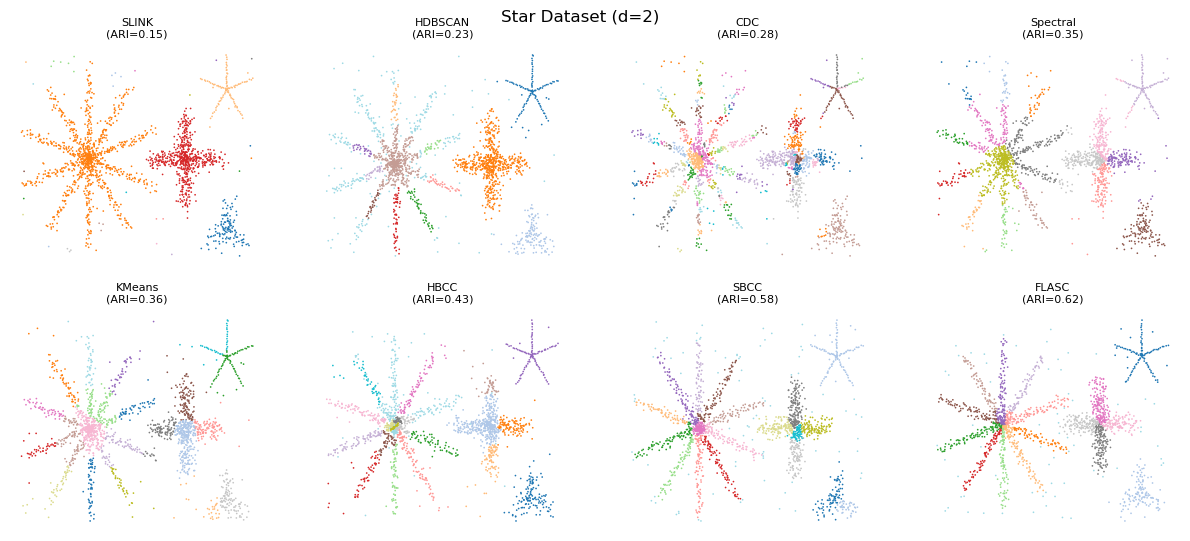

In [10]:
plt.figure(figsize=(12, 6))
algs = ["slink", "hdbscan", "cdc", "spectral", "kmeans", "hbcc", "sbcc", "flasc"]
names = ['SLINK', 'HDBSCAN', 'CDC', 'Spectral', 'KMeans', "HBCC", "SBCC", 'FLASC']
cnt = 1
for alg, alg_name in zip(algs, names):
    plt.subplot(2, 4, cnt)
    plt.xticks([])
    plt.yticks([])
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["bottom"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    cnt += 1
    row = best_cases.query("alg == @alg")
    if row.shape[0] == 0:
        plt.text(0.5, 0.5, "N/A", fontsize=10, ha="center", va="center")
        plt.title(f"{alg_name}\n", fontsize=8)
        continue
    plt.title(f"{alg_name}\n(ARI={row.ari.iloc[0]:.2f})", fontsize=8)
    
    plt.scatter(
        *np.load(
            f"data/generated/star_parameter_sweep_X_{row.repeat.iloc[0]}.npy"
        )[:, :2].T,
        s=1.5,
        c=row.labels.iloc[0] % 20,
        cmap="tab20",
        vmin=0,
        vmax=19,
        edgecolors="none",
        linewidths=0,
    )
plt.subplots_adjust(left=0.025, right=1, top=0.92)
plt.suptitle(f"Star Dataset (d=2)", fontsize=12)
plt.show()

### Higher Dimensions Data

Just to check, we now run the algorithms on 8D and 16D data with their optimal
parameters found on 2D data. Only the noise is present in the higher dimensions.
Performance increases for FLASC. HBCC and SBCC seem to have trouble with the
additional dimensions. It appears the boundary coefficient needs tuning for
these cases.

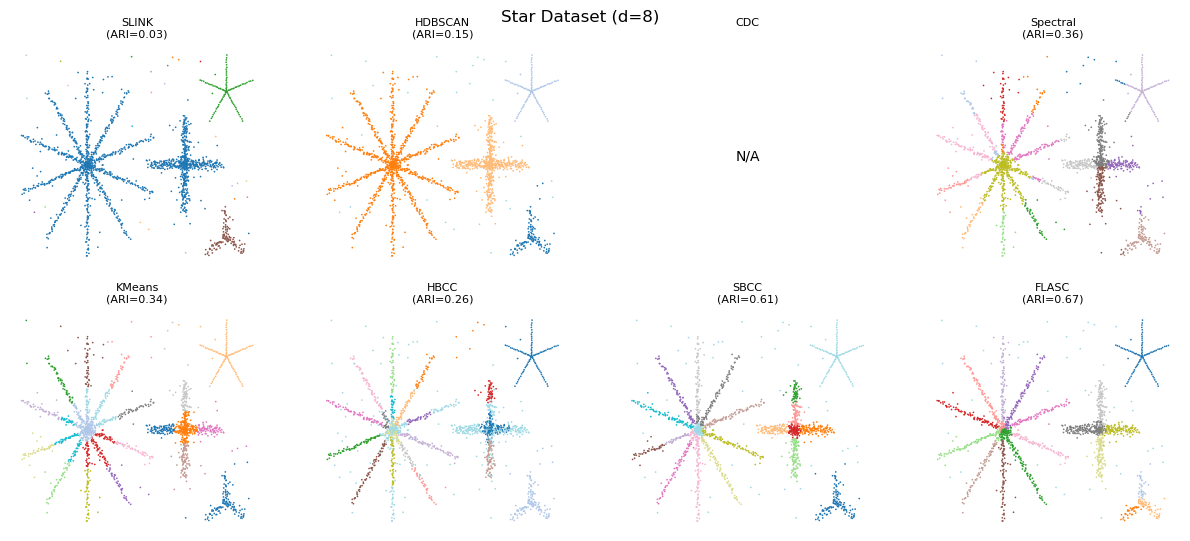

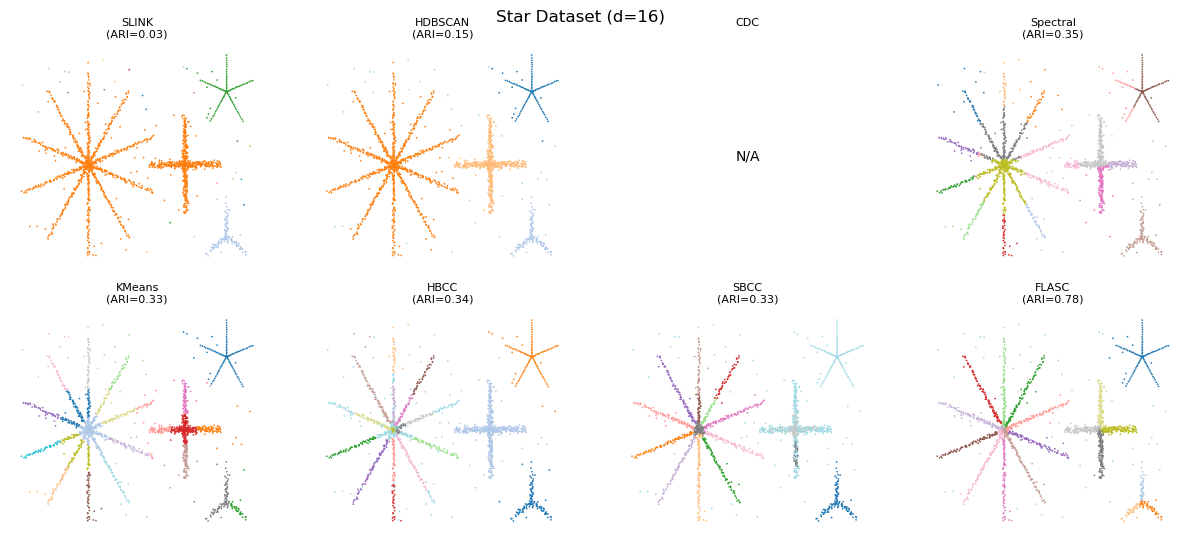

In [11]:
for d in [8, 16]:
    X, y = make_stars_dataset(num_dimensions=d)

    plt.figure(figsize=(12, 6))
    cnt = 1
    for alg, alg_name in zip(algs, names):
        plt.subplot(2, 4, cnt)
        plt.xticks([])
        plt.yticks([])
        plt.gca().spines["top"].set_visible(False)
        plt.gca().spines["right"].set_visible(False)
        plt.gca().spines["bottom"].set_visible(False)
        plt.gca().spines["left"].set_visible(False)
        cnt += 1
        if alg == "cdc":
            plt.text(0.5, 0.5, "N/A", fontsize=10, ha="center", va="center")
            plt.title(f"{alg_name}\n", fontsize=8)
            continue

        row = best_cases.query("alg == @alg")
        kwargs = static_params[alg]
        params = {k: row[k].iloc[0] for k in dynamic_params[alg].keys()}
        params = {
            k: int(v) if isinstance(v, np.floating) else str(v)
            for k, v in params.items()
        }
        if alg in ["sbcc", "flasc"]:
            hkwargs = static_params["hdbscan"]
            hparams = {k: row[k].iloc[0] for k in dynamic_params["hdbscan"].keys()}
            hparams = {
                k: int(v) if isinstance(v, np.floating) else str(v)
                for k, v in hparams.items()
            }
            cc = HDBSCAN(**hkwargs, **hparams).fit(X)
            dd = post_processors[alg](**kwargs).fit(cc)
            labels = dd.fit_predict(cc)
        else:
            labels = algorithms[alg](**kwargs, **params).fit_predict(X)
        ari = adjusted_rand_score(y, labels)
        plt.title(f"{alg_name}\n(ARI={ari:.2f})", fontsize=8)

        plt.scatter(
            *X[:, :2].T,
            s=1.5,
            c=labels % 20,
            cmap="tab20",
            vmin=0,
            vmax=19,
            edgecolors="none",
            linewidths=0,
        )
    plt.subplots_adjust(left=0.025, right=1, top=0.92)
    plt.suptitle(f"Star Dataset (d={X.shape[1]})", fontsize=12)
    plt.show()

### Parameter Sensitivity

Now we explore the algorithm's parameter sensitivity using average ARI and
compute time over the 5 repeated runs.

In [12]:
avg_df = result_df.query("repeat == 0")[["alg", *all_params]].copy()
avg_df["ari"] = np.mean(
    np.stack([result_df.query("repeat == @i").ari.values for i in range(5)]),
    axis=0,
)
avg_df["time"] = np.mean(
    np.stack([result_df.query("repeat == @i").time.values for i in range(5)]),
    axis=0,
)

#### kMeans, SLINK, Spectral

These algorithms require the number of clusters as input. The true number is 23
and performance peaks around there for these algorithms.

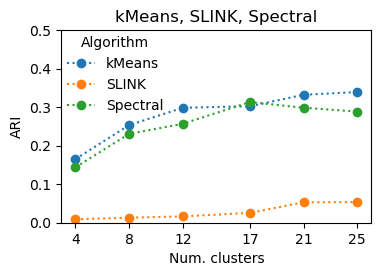

In [13]:
plt.figure(figsize=(4, 2.5))
avg_df[~np.isnan(avg_df.n_clusters)].pivot(
    index="n_clusters", columns="alg", values="ari"
).plot(xlabel="Num. clusters", ylabel="ARI", linestyle=":", marker="o", ax=plt.gca())
plt.legend(
    ["kMeans", "SLINK", "Spectral"], title="Algorithm", borderaxespad=0, frameon=False
)
plt.xticks(n_clusters)
plt.ylim(0, 0.5)
plt.title("kMeans, SLINK, Spectral")
plt.show()

#### HDBSCAN

HDBSCAN performs best with low `min_samples` and `min_cluster_size` because that
is when it is most sensitive to small density peaks---the only way in which it
can detect clusters that do not have a reliable density peak.

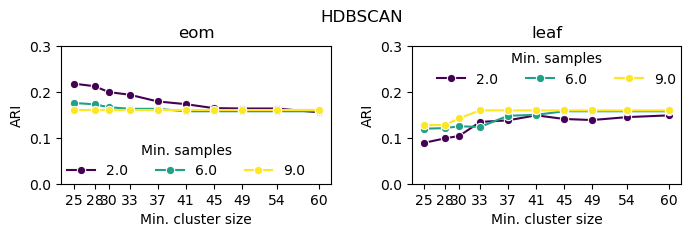

In [14]:
import seaborn as sns

plt.figure(figsize=(8, 2))
for i, strat in enumerate(["eom", "leaf"]):
    plt.subplot(1, 2, i + 1)
    sns.lineplot(
        avg_df.query(
            "alg == 'hdbscan' and "
            "min_samples < 10 and " 
            "cluster_selection_method==@strat"
        ).rename(
            columns=dict(
                min_samples="Min. samples", cluster_selection_method="Selection"
            )
        ),
        marker="o",
        x="min_cluster_size",
        y="ari",
        hue="Min. samples",
        palette="viridis",
    )
    plt.legend(ncols=3, borderaxespad=0, frameon=False, title='Min. samples')
    plt.xticks(min_cluster_sizes)
    plt.xlabel("Min. cluster size")
    plt.ylabel("ARI")
    plt.ylim(0, 0.3)
    plt.title(strat)
plt.suptitle("HDBSCAN")
plt.subplots_adjust(wspace=0.3, top=0.8)
plt.show()

#### FLASC (BranchDetector)

FLASC performs well on a larger range of parameter values. It needs a relatively
low `min_samples` to avoid `min_samples`-nearest neighbors connecting branches
at high eccentricity values. The minimum cluster size needs to be smaller than
the true number of points in the smallest branch. Too small values tend to
produce spurious branches. In this case, values between 25 and 49 work well. The
`leaf` selection strategy is more sensitive to `min_samples`, as it 
influences the number of leafs.

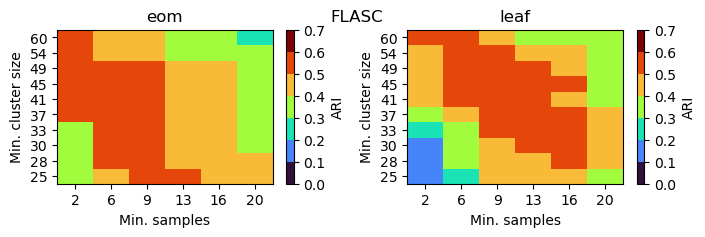

In [15]:
import matplotlib as mpl
from matplotlib.colors import BoundaryNorm

bounds = np.linspace(0, 0.7, 8)
cmap = mpl.colormaps["turbo"]
norm = BoundaryNorm(bounds, cmap.N)


plt.figure(figsize=(8, 2))
for i, strat in enumerate(["eom", "leaf"]):
    plt.subplot(1, 2, i + 1)
    flasc2d = avg_df.query("alg=='flasc' and cluster_selection_method==@strat")
    plt.imshow(
        flasc2d.pivot(index="min_cluster_size", columns="min_samples", values="ari"),
        origin="lower",
        aspect="auto",
        cmap=cmap,
        norm=norm,
    )
    plt.xticks(range(len(n_neighbors)))
    plt.yticks(range(len(min_cluster_sizes)))
    plt.gca().set_xticklabels([f"{int(x)}" for x in n_neighbors])
    plt.gca().set_yticklabels([f"{int(x)}" for x in min_cluster_sizes])

    plt.xlabel("Min. samples")
    plt.ylabel("Min. cluster size")
    plt.colorbar(label="ARI")
    plt.title(strat)
plt.subplots_adjust(wspace=0.3)
plt.suptitle("FLASC")
plt.show()

#### HBCC

HBCC's parameters influence both the shape of the coreness profile as well as
the way in which clusters are extracted from the profile. Generally, for this
data set, low values for `num_hops` and `min_samples` are needed for there to be
coreness maxima in the branches. When those maxima exist, `min_cluster_size` can
vary between 25 to 60, indicating a lower sensitivity.

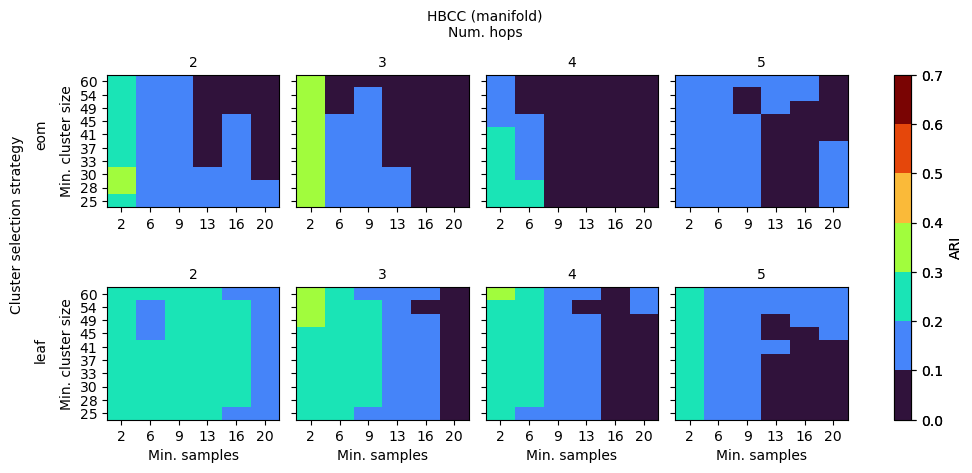

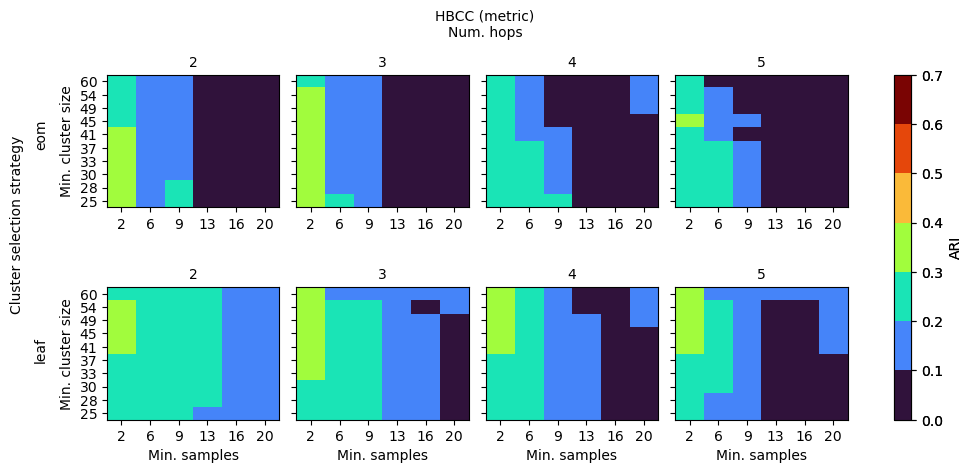

In [16]:
for hoptype in hop_types:
    plt.figure(figsize=(12, 5))
    for j, strat in enumerate(["eom", "leaf"]):
        hbcc2d = avg_df.query("alg=='hbcc' and cluster_selection_method==@strat and hop_type==@hoptype")
        for i, bs in enumerate(n_hops):
            plt.subplot(2, 5, j * 5 + i + 1)
            plt.imshow(
                hbcc2d.query("num_hops == @bs").pivot(
                    index="min_cluster_size", columns="min_samples", values="ari"
                ),
                origin="lower",
                aspect="auto",
                cmap=cmap,
                norm=norm,
            )
            plt.xticks(range(len(n_neighbors)))
            plt.yticks(range(len(min_cluster_sizes)))
            plt.gca().set_xticklabels([f"{int(x)}" for x in n_neighbors])
            plt.gca().set_yticklabels([f"{int(x)}" for x in min_cluster_sizes])

            if j == 1:
                plt.xlabel("Min. samples")
            if i == 0:
                plt.ylabel("Min. cluster size")
            else:
                plt.gca().set_yticklabels(["" for _ in min_cluster_sizes])
            plt.title(f"{bs}", fontsize=10)

        ax = plt.subplot(1, 6, 6)
        plt.colorbar(ax=ax, aspect=20, pad=0, fraction=1, label="ARI")
        plt.axis("off")
        plt.text(
            0.07,
            0.68 if j == 0 else 0.25,
            strat,
            fontsize=10,
            ha="center",
            va="center",
            rotation=90,
            transform=plt.gcf().transFigure,
        )
    plt.text(
        0.44,
        0.9,
        f"HBCC ({hoptype})\nNum. hops",
        fontsize=10,
        ha="center",
        va="center",
        transform=plt.gcf().transFigure,
    )
    plt.text(
        0.05,
        0.5,
        "Cluster selection strategy",
        fontsize=10,
        ha="center",
        va="center",
        rotation=90,
        transform=plt.gcf().transFigure,
    )
    plt.subplots_adjust(top=0.8, hspace=0.6, wspace=0.1)
    plt.show()

#### SBCC (BoundaryClusterDetector)

SBCC's parameters behave a bit differently. Noise is already dealt with by
HDBSCAN, so slightly larger `num_hops` and `min_samples` create a smoother
coreness profile to extract the clusters from. Separating the cluster selection
strategy between the HDBSCAN and HBCC stages would provide a larger range of
good performing parameter values, as HDBCC works best with `leaf`, while HDBSCAN
is most stable with `eom`.

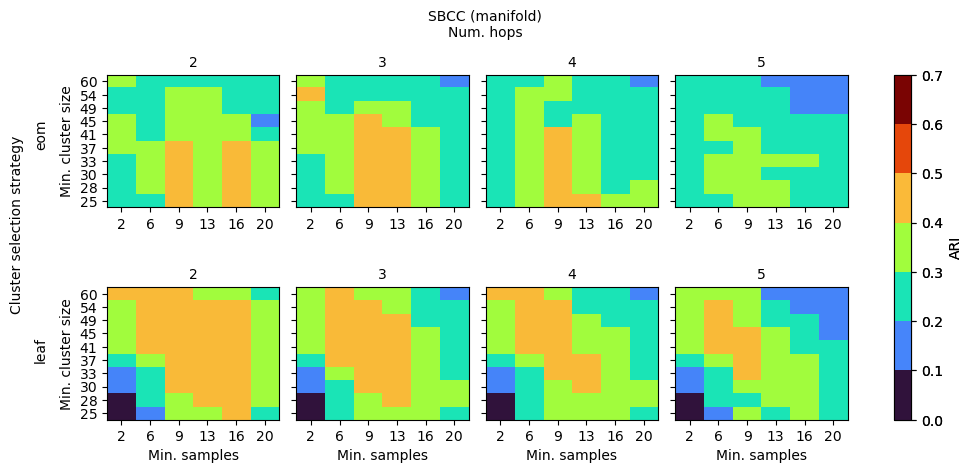

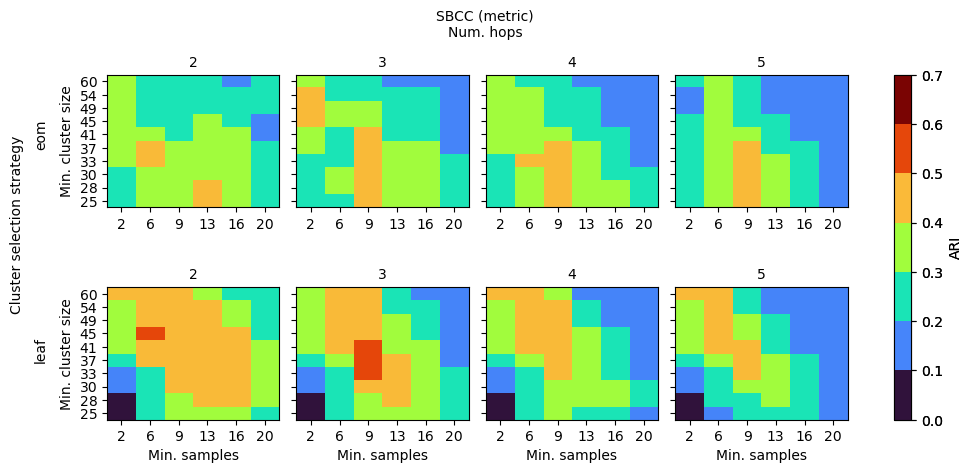

In [17]:
for hoptype in hop_types:
    plt.figure(figsize=(12, 5))
    for j, strat in enumerate(["eom", "leaf"]):
        sbcc2d = avg_df.query("alg=='sbcc' and cluster_selection_method==@strat and hop_type==@hoptype")
        for i, bs in enumerate(n_hops):
            plt.subplot(2, 5, j * 5 + i + 1)
            plt.imshow(
                sbcc2d.query("num_hops == @bs").pivot(
                    index="min_cluster_size", columns="min_samples", values="ari"
                ),
                origin="lower",
                aspect="auto",
                cmap=cmap,
                norm=norm,
            )
            plt.xticks(range(len(n_neighbors)))
            plt.yticks(range(len(min_cluster_sizes)))
            plt.gca().set_xticklabels([f"{int(x)}" for x in n_neighbors])
            plt.gca().set_yticklabels([f"{int(x)}" for x in min_cluster_sizes])

            if j == 1:
                plt.xlabel("Min. samples")
            if i == 0:
                plt.ylabel("Min. cluster size")
            else:
                plt.gca().set_yticklabels(["" for _ in min_cluster_sizes])
            plt.title(f"{bs}", fontsize=10)

        ax = plt.subplot(1, 6, 6)
        plt.colorbar(ax=ax, aspect=20, pad=0, fraction=1, label="ARI")
        plt.axis("off")
        plt.text(
            0.07,
            0.68 if j == 0 else 0.25,
            strat,
            fontsize=10,
            ha="center",
            va="center",
            rotation=90,
            transform=plt.gcf().transFigure,
        )
    plt.text(
        0.44,
        0.9,
        f"SBCC ({hoptype})\nNum. hops",
        fontsize=10,
        ha="center",
        va="center",
        transform=plt.gcf().transFigure,
    )
    plt.text(
        0.05,
        0.5,
        "Cluster selection strategy",
        fontsize=10,
        ha="center",
        va="center",
        rotation=90,
        transform=plt.gcf().transFigure,
    )
    plt.subplots_adjust(top=0.8, hspace=0.6, wspace=0.1)
    plt.show()

### HBCC Compute Time

Compute cost for the boundary coefficient increases with the product of
`num_hops` and `min_samples` because `num_hop` controls the depth of a
Dijkstra's shortest path algorithm and `min_samples` controls the number of
edges each point has. Furthermore, computing the boundary coefficient relies on
a sparse matrix multiplication, which scales by the number of edges in the
expanded graph.

In the figure below, HDBSCAN's time is shown in black. It appears one code path
for HDBSCAN was not pre-compiled, leading to the larger uncertainty at
`min_samples=2`.

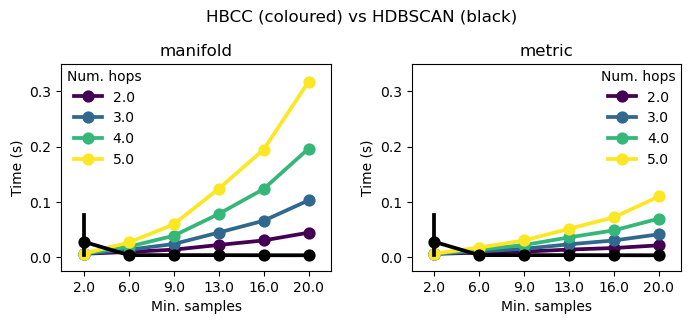

In [18]:
plt.figure(figsize=(8, 3))
for i, hoptype in enumerate(hop_types):
    plt.subplot(1, 2, i+1)
    sns.pointplot(
        avg_df.query("alg=='hbcc' and cluster_selection_method==@strat and hop_type==@hoptype"),
        x="min_samples",
        y="time",
        hue="num_hops",
        marker="o",
        palette="viridis",
        legend=True,
    )
    sns.pointplot(
        avg_df.query("alg == 'hdbscan'"),
        x="min_samples",
        y="time",
        color="k",
        legend=False,
    )
    plt.legend(title="Num. hops", borderaxespad=0, frameon=False)
    plt.xlabel("Min. samples")
    plt.ylabel("Time (s)")
    plt.ylim([-0.025, 0.35])
    plt.title(hoptype)
plt.suptitle("HBCC (coloured) vs HDBSCAN (black)")
plt.subplots_adjust(wspace=0.3, top=0.8)
plt.show()